<a href="https://colab.research.google.com/github/hrirhea/Verification-of-Sunchronous-FIFO/blob/main/meme_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'memesdataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5143128%2F8596961%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T085250Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D36038a56dbbc146f6c169bd728b99f34737bd698e0c77666d1012a88f9341e6f8e27c81996dfd672bd70962cd60fd2f671c5868da3cb24712801961772339899f73979eb3809d64d4c57f0f557209d53a5fcd6761f2ed4d7efb386d6d115cc6d161b511939d528dddb2f69788a7654710658585c31abbce378b5394563c92dd22d902dc7c07c978cab740bb10dde64c41acf604ab0774eb7f5cff5b3f58c9983acc1dcc8800336ec2539493a56f4e892e9bca88142c171db37cd4837a86a3110915adbd009c00597d050fbd9e493c4641096f9ce51a1b8efa32fbf822a64395133c5d818f0fb49715786db09257564aa1c3daad13aaee194fb0df67c030a76dd,memesdataset2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5143451%2F8597397%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T085250Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D025b129f976829cd81b8197ba382cdb16c1b077f5873f8782d108f0fcb3bf7ab488ac60c0a0aa66e1b5679039d7a6e60d8cd800c983127db25751087b53df6081d99d4205f7ce57c32e5d58997c739b887b87a0936d8b8b54abdc6089851613a5d2237fdc95c06f2e764dac25c26156cb3c050af5c16c60336da1a0bab851c76d42c01d395452c763545e20fc6b76e8e220564c16f4926e59ad88566451f57536b988728ea14102cba0976c27f4479d05464de22e754b519da7a0bab10a7b5ece764cdd56edd2f4e8a0876ad5fe4edc80f457263400b5a50113bfdf4ba2f3a4d7a441182b568b8438f2656781dd81b169c35fe4e417d87dbcb72e794ea68d3f0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 755845 bytes downloaded
Downloaded and uncompressed: memesdataset
[==================================================] 1689349233 bytes downloaded
Downloaded and uncompressed: memesdataset2
Data source import complete.


In [2]:
import pandas as pd
#import datasets
#from datasets import load_dataset
import transformers
from transformers import BlipProcessor, BlipForImageTextRetrieval,BlipForConditionalGeneration, AutoProcessor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import os

import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import cv2
import shutil
import json
from PIL import Image
import requests
from matplotlib import pyplot as plt

In [3]:



# Load the JSON data
with open(r'/kaggle/input/memesdataset/memes-trainval.json') as f:
    data = json.load(f)

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Preview the first few rows
print(df.head())


  category                                       img_captions  \
0    memes  [Person in Spider Man outfit gives a lecture o...   
1    memes  [Two dogs carry a white flag, Identical chubby...   
2    memes  [man is very dissatisfied with what he sees, Q...   
3    memes  [A man that is crying and a man that is laughi...   
4    memes  [a cop is chasing a thief with a shopping cart...   

                                       meme_captions  \
0  [Meme poster is frustrated about the format of...   
1  [Meme poster is saying that searching Google p...   
2                      [Meme poster is feeling sad.]   
3  [Meme poster is saying that Reddit is more fun...   
4   [Meme poster is making fun of the Area 51 raid.]   

                                        title  \
0                             For real though   
1                           And that's a fact   
2                             It was horrible   
3                This is why Reddit is better   
4  The Area 51 raid is stil

In [4]:
# Summary statistics for numerical columns (if any)
print(df.describe())

# Basic information about the DataFrame
print(df.info())


       category                       img_captions  \
count      5823                               5823   
unique        1                               5480   
top       memes  [A frog is wearing a fancy suit.]   
freq       5823                                 17   

                                            meme_captions       title  \
count                                                5823        5818   
unique                                               5823        5736   
top     [Meme poster tries to fancy up saying their pi...  Every time   
freq                                                    1           9   

                                        url         img_fname metaphors  \
count                                  5823              5823      5822   
unique                                 5822              5823      4726   
top     https://i.redd.it/n4ildkpurph61.png  memes_zd12m0.png        []   
freq                                      2                 1  

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


category         0
img_captions     0
meme_captions    0
title            5
url              0
img_fname        0
metaphors        1
post_id          0
dtype: int64


In [6]:
# Option 1: Removing rows with missing values
df.dropna(inplace=True)  # This will remove rows with any missing values


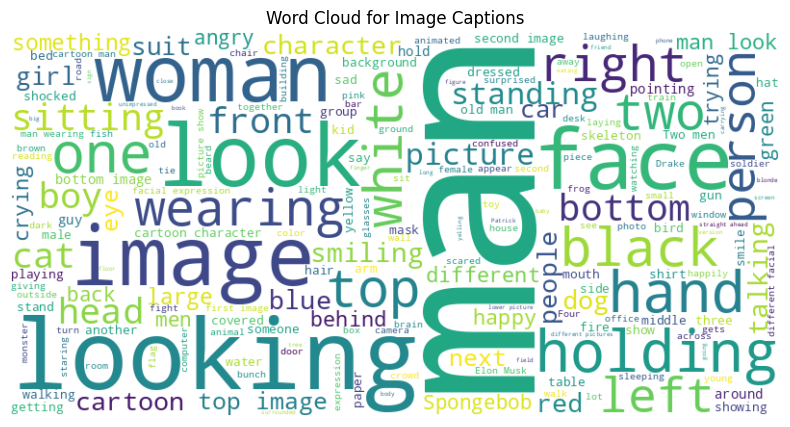

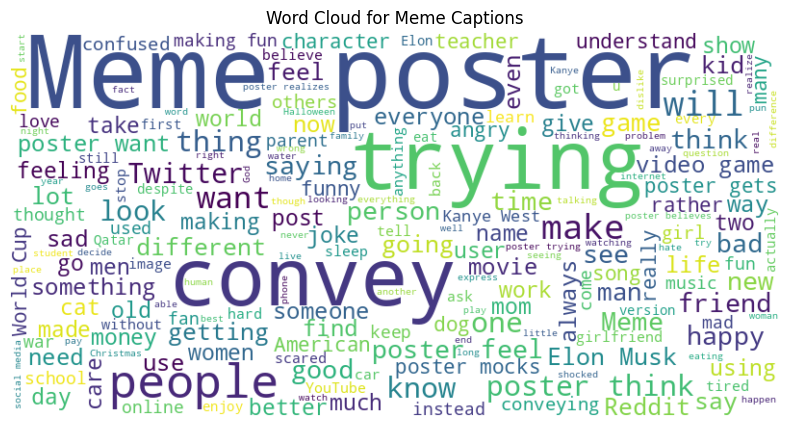

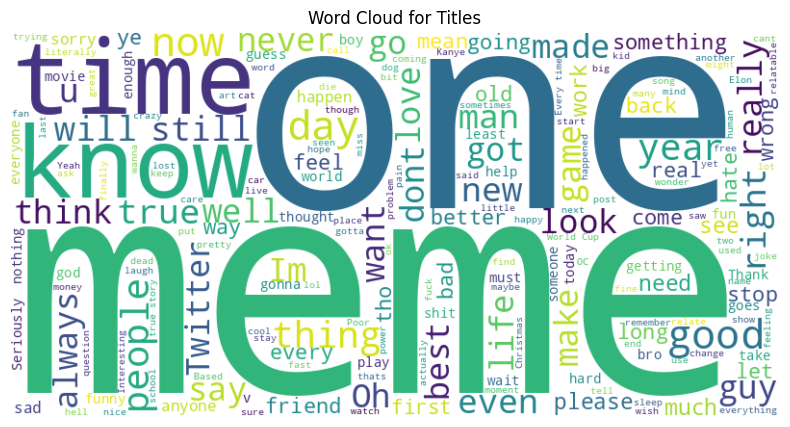

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure all entries are strings and concatenate them into one large string for each column
def concatenate_text(data, column):
    text_data = ''
    for entry in data[column].dropna():
        if isinstance(entry, list):
            entry = ' '.join(entry)  # Convert list to string
        text_data += ' ' + str(entry)
    return text_data

# Function to generate and display word cloud
def generate_word_cloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for img_captions
img_captions_text = concatenate_text(df, 'img_captions')
generate_word_cloud(img_captions_text, 'Word Cloud for Image Captions')

# Generate word cloud for meme_captions
meme_captions_text = concatenate_text(df, 'meme_captions')
generate_word_cloud(meme_captions_text, 'Word Cloud for Meme Captions')

# Generate word cloud for title
title_text = concatenate_text(df, 'title')
generate_word_cloud(title_text, 'Word Cloud for Titles')




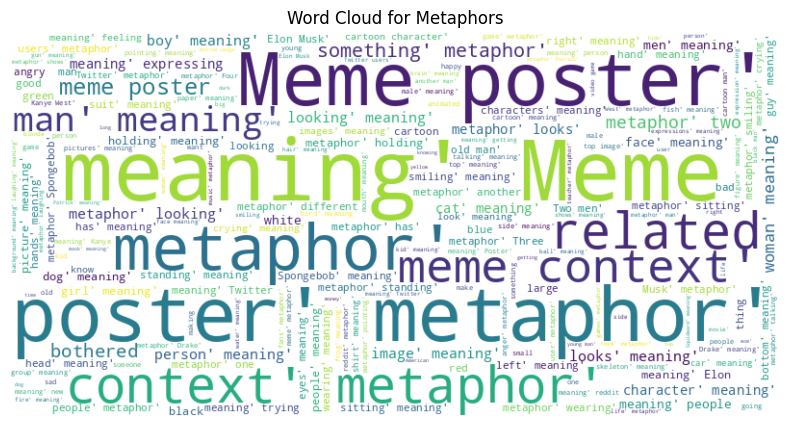

In [8]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt




# Function to flatten a dictionary into a string by concatenating 'metaphor' and 'meaning' values
def flatten_metaphor_entry(entry):
    if isinstance(entry, dict):
        metaphor = entry.get('metaphor', '')
        meaning = entry.get('meaning', '')
        return f'{metaphor} {meaning}'
    return str(entry)

# Concatenate all entries in the metaphors column into one large string
metaphors_text = ' '.join(df['metaphors'].dropna().apply(flatten_metaphor_entry))

# Function to generate and display word cloud
def generate_word_cloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for metaphors
generate_word_cloud(metaphors_text, 'Word Cloud for Metaphors')



In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity




# Convert lists to strings
df['img_captions'] = df['img_captions'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['meme_captions'] = df['meme_captions'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Compute TF-IDF vectors for img_captions and meme_captions
vectorizer = TfidfVectorizer()
tfidf_img_captions = vectorizer.fit_transform(df['img_captions'].fillna(''))
tfidf_meme_captions = vectorizer.transform(df['meme_captions'].fillna(''))  # Use transform instead of fit_transform

# Compute cosine similarity
cosine_similarities = cosine_similarity(tfidf_img_captions, tfidf_meme_captions)
print(cosine_similarities)


[[0.01177902 0.0049338  0.         ... 0.01910422 0.         0.        ]
 [0.         0.         0.         ... 0.13912202 0.         0.        ]
 [0.03106333 0.01489212 0.10414033 ... 0.05381175 0.01206457 0.        ]
 ...
 [0.         0.00834373 0.         ... 0.08669073 0.02027854 0.02136808]
 [0.04090565 0.02016167 0.01376949 ... 0.01320218 0.04642182 0.02448422]
 [0.03388344 0.01624411 0.02109892 ... 0.         0.01315986 0.1676486 ]]


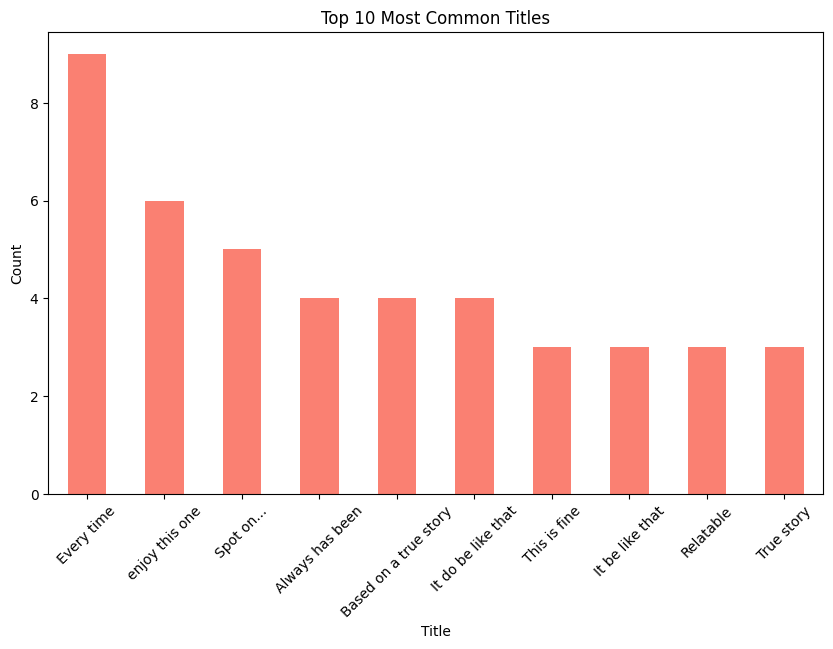

In [10]:
plt.figure(figsize=(10, 6))
df['title'].value_counts().nlargest(10).plot(kind='bar', color='salmon')
plt.title('Top 10 Most Common Titles')
plt.xlabel('Title')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

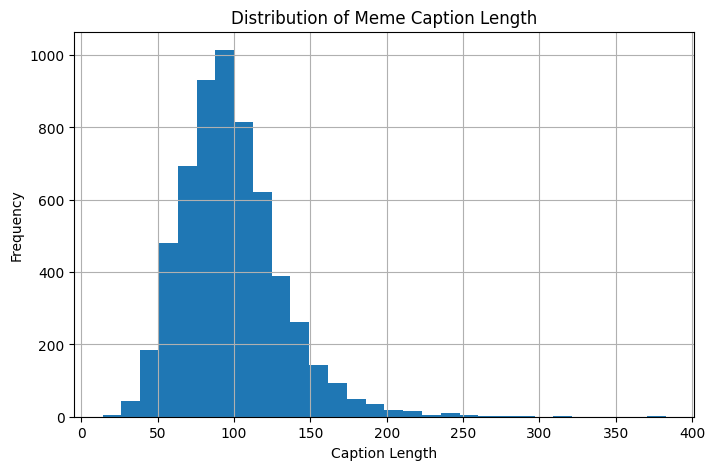

In [11]:
plt.figure(figsize=(8, 5))
df['meme_captions'].str.len().hist(bins=30)
plt.title('Distribution of Meme Caption Length')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()


In [12]:

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Preprocess Text Data
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(tokens)

df['title'] = df['title'].apply(preprocess_text)
df['url'] = df['url'].apply(preprocess_text)

# Encode Categorical Data
df = pd.get_dummies(df, columns=['category'])

# Preprocess List Data
def preprocess_list(list_data):
    # Flatten the list and preprocess each item
    flat_list = [item.lower() for sublist in list_data for item in sublist]
    return ' '.join(flat_list)

df['img_captions'] = df['img_captions'].apply(preprocess_list)
df['meme_captions'] = df['meme_captions'].apply(preprocess_list)

# Extract Information from Dictionary Data (if needed)
# For example, extract keys or values from the dictionary

# Now, your DataFrame 'df' is preprocessed and ready for further analysis.


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [13]:
df.head

<bound method NDFrame.head of      category                                       img_captions  \
0       memes  Person in Spider Man outfit gives a lecture on...   
1       memes  Two dogs carry a white flag Identical chubby a...   
2       memes  man is very dissatisfied with what he sees Que...   
3       memes  A man that is crying and a man that is laughin...   
4       memes  a cop is chasing a thief with a shopping cart ...   
...       ...                                                ...   
5818    memes  The middle aged somewhat bolding man is at a s...   
5819    memes     A woman is deep in thought throughout the day.   
5820    memes  Captain America talks to a man in a elevator t...   
5821    memes  two drawn faces face to face and right one is ...   
5822    memes                    A frog is wearing a fancy suit.   

                                          meme_captions  \
0     Meme poster is frustrated about the format of ...   
1     Meme poster is saying that searching Google pl...   
2                           Meme poster is feeling sad.   
3     Meme poster is saying that Reddit is more fun ...   
4        Meme poster is making fun of the Area 51 raid.   
...                                                 ...   
5818   Poster is low on funds towards end of the month.   
5819  The poster is pretending to think when they ar...   
5820  The meme poster exposed that he could fight wi...   
5821  Meme poster is trying to convey that Anime fan...   
5822  Meme poster tries to fancy up saying their pil...   

                                                  title  \
0                                       For real though   
1                                     And that's a fact   
2                                       It was horrible   
3                          This is why Reddit is better   
4            The Area 51 raid is still happening right?   
...                                                 ...   
5818  Posting memes until I get my master's degree d...   
5819                                *pretends to think*   
5820                                overreaction indeed   
5821                             Anime watchers be like   
5822  Gentlemen, is with great pleasure to inform yo...   

                                                    url         img_fname  \
0                   https://i.redd.it/m16dhaqyply21.jpg  memes_bpet7l.png   
1                   https://i.redd.it/z9oh7ligb0i31.jpg  memes_ctxvmu.png   
2                   https://i.redd.it/yves3izsbsj31.jpg  memes_cxvuqd.png   
3                   https://i.redd.it/y594n8exi6k31.jpg  memes_cyop7a.png   
4                   https://i.redd.it/4hrn18t4lck31.jpg  memes_cz2i20.png   
...                                                 ...               ...   
5818                https://i.redd.it/p5t3m0ujt24a1.jpg  memes_zd0n76.png   
5819                https://i.redd.it/yyru9fqbu24a1.jpg  memes_zd0pqv.png   
5820                https://i.redd.it/n2qnaoztu24a1.jpg  memes_zd0rgl.png   
5821  https://farm66.staticflickr.com/65535/52761413...  memes_zd0s2c.png   
5822                https://i.redd.it/f6b53ppyx24a1.jpg  memes_zd12m0.png   

                                              metaphors post_id  
0     [{'metaphor': 'Spider Man outfit', 'meaning': ...  bpet7l  
1     [{'metaphor': 'Two dogs', 'meaning': 'Meme pos...  ctxvmu  
2     [{'metaphor': 'man', 'meaning': 'Meme poster'}...  cxvuqd  
3     [{'metaphor': 'A man', 'meaning': 'Meme poster...  cyop7a  
4     [{'metaphor': 'a cop', 'meaning': 'Meme poster...  cz2i20  
...                                                 ...     ...  
5818  [{'metaphor': 'somewhat bolding man', 'meaning...  zd0n76  
5819  [{'metaphor': 'A woman', 'meaning': 'the poste...  zd0pqv  
5820  [{'metaphor': 'Captain America', 'meaning': 'M...  zd0rgl  
5821  [{'metaphor': 'two drawn faces', 'meaning': 'a...  zd0s2c  
5822  [{'metaphor': 'A frog', 'meaning': 'Meme poste...  zd12m0  

[5817 rows x 8 co

In [14]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

#from peft import LoraConfig, get_peft_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
loc = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(loc)
model = BlipForConditionalGeneration.from_pretrained(loc)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [17]:
print_trainable_parameters(model)

trainable params: 247414076 || all params: 247414076 || trainable%: 100.0


In [18]:
df['images'] = r"/kaggle/input/memesdataset2/memes" + "/" +df['img_fname']
df.head()

,category,img_captions,meme_captions,title,url,img_fname,metaphors,post_id,images
0,memes,Person in Spider Man outfit gives a lecture on...,Meme poster is frustrated about the format of ...,For real though,https://i.redd.it/m16dhaqyply21.jpg,memes_bpet7l.png,"[{'metaphor': 'Spider Man outfit', 'meaning': ...",bpet7l,/kaggle/input/memesdataset2/memes/memes_bpet7l...
1,memes,Two dogs carry a white flag Identical chubby a...,Meme poster is saying that searching Google pl...,And that's a fact,https://i.redd.it/z9oh7ligb0i31.jpg,memes_ctxvmu.png,"[{'metaphor': 'Two dogs', 'meaning': 'Meme pos...",ctxvmu,/kaggle/input/memesdataset2/memes/memes_ctxvmu...
2,memes,man is very dissatisfied with what he sees Que...,Meme poster is feeling sad.,It was horrible,https://i.redd.it/yves3izsbsj31.jpg,memes_cxvuqd.png,"[{'metaphor': 'man', 'meaning': 'Meme poster'}...",cxvuqd,/kaggle/input/memesdataset2/memes/memes_cxvuqd...
3,memes,A man that is crying and a man that is laughin...,Meme poster is saying that Reddit is more fun ...,This is why Reddit is better,https://i.redd.it/y594n8exi6k31.jpg,memes_cyop7a.png,"[{'metaphor': 'A man', 'meaning': 'Meme poster...",cyop7a,/kaggle/input/memesdataset2/memes/memes_cyop7a...
4,memes,a cop is chasing a thief with a shopping cart ...,Meme poster is making fun of the Area 51 raid.,The Area 51 raid is still happening right?,https://i.redd.it/4hrn18t4lck31.jpg,memes_cz2i20.png,"[{'metaphor': 'a cop', 'meaning': 'Meme poster...",cz2i20,/kaggle/input/memesdataset2/memes/memes_cz2i20...


In [19]:

import os
folder_path = r"/kaggle/working/memestrain"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)


In [20]:
import shutil

In [21]:

for index, row in df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    shutil.copy(source_file, folder_path)


In [22]:
df["title"]=r" the title of the image is "+df["title"]

In [23]:
for caption in df["img_captions"]:
  df["caption"]=caption[0]

In [24]:
for metaphor in df["metaphors"]:
  df["metaphor_to_use"]=" metaphors used are "
  for meta in metaphor:
    df["metaphor_to_use"]+=meta["metaphor"]+ "for "+ meta["meaning"]

In [25]:
for meme in df["meme_captions"]:
  df["meme_cap"]=meme[0]

In [27]:
df["prompt"]="image caption is "+df["caption"] +df["metaphor_to_use"]+ df["title"]+" .Generate a meme caption "+  df["meme_cap"]

In [28]:
final = df.apply(lambda row: {"file_name": row["img_fname"], "text": row["prompt"]}, axis=1).tolist()

In [29]:

with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in final:
        f.write(json.dumps(item))


In [31]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [32]:
from datasets import load_dataset

In [33]:
dataset = load_dataset("imagefolder", data_dir=folder_path,split="train")


Resolving data files:   0%|          | 0/5818 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [34]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 5817
})

In [35]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, image_size=(224, 224)):
        self.dataset = dataset
        self.processor = processor
        self.image_size = image_size
        self.resize_transform = Resize(image_size)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [36]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize

In [37]:
image_size = (224, 224)
train_dataset = ImageCaptioningDataset(dataset, processor, image_size)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)
train_dataloader

In [39]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [40]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 33.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [41]:
from peft import LoraConfig, get_peft_model

In [42]:

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query","value"],
)

peft_model = get_peft_model(model, config)

In [43]:
print_trainable_parameters(peft_model)

trainable params: 1179648 || all params: 248593724 || trainable%: 0.4745284720059948


In [44]:
print(train_dataloader)

In [45]:
for name, param in model.named_parameters():
    if name.startswith("conv") and int(name.split(".")[1]) <= 12:
        param.requires_grad = False  # This is equivalent to setting trainable=False


In [46]:

from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

In [47]:
total_step = len(train_dataloader)
total_step

2909

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
peft_model.to(device)

peft_model.train()


for epoch in range(5):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = peft_model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

        loss = outputs.loss

        print("Loss:", loss.item())
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()



Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 12.814996719360352
Loss: 12.827569007873535
Loss: 12.760915756225586
Loss: 12.800491333007812
Loss: 12.817227363586426
Loss: 12.780701637268066
Loss: 12.78539752960205
Loss: 12.827610969543457
Loss: 12.771136283874512
Loss: 12.858224868774414
Loss: 12.753759384155273
Loss: 12.843820571899414
Loss: 12.795853614807129
Loss: 12.782896995544434
Loss: 12.890361785888672
Loss: 12.801175117492676
Loss: 12.841376304626465
Loss: 12.789072036743164
Loss: 12.789655685424805
Loss: 12.81630802154541
Loss: 12.803543090820312
Loss: 12.750190734863281
Loss: 12.79507064819336
Loss: 12.788540840148926
Loss: 12.832919120788574
Loss: 12.841083526611328
Loss: 12.794722557067871
Loss: 12.841546058654785
Loss: 12.834378242492676
Loss: 12.798516273498535
Loss: 12.812044143676758
Loss: 12.802864074707031
Loss: 12.78087043762207
Loss: 12.864840507507324
Loss: 12.821707725524902
Loss: 12.890134811401367
Loss: 12.778202056884766
Loss: 12.837943077087402
Loss: 12.819130897521973
Loss: 12.792961120605469
Loss

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Loss: 12.820856094360352
Loss: 12.752763748168945
Loss: 12.818289756774902
Loss: 12.817233085632324
Loss: 12.808305740356445
Loss: 12.84787368774414
Loss: 12.787468910217285
Loss: 12.850150108337402
Loss: 12.778037071228027
Loss: 12.728841781616211
Loss: 12.777904510498047
Loss: 12.7827787399292
Loss: 12.847478866577148
Loss: 12.778862953186035
Loss: 12.835960388183594
Loss: 12.832406997680664
Loss: 12.853225708007812
Loss: 12.741296768188477
Loss: 12.81228256225586
Loss: 12.826319694519043
Loss: 12.773367881774902
Loss: 12.793206214904785
Loss: 12.778143882751465
Loss: 12.792862892150879
Loss: 12.82972240447998
Loss: 12.837627410888672
Loss: 12.861227035522461
Loss: 12.798516273498535
Loss: 12.758708000183105
Loss: 12.836345672607422
Loss: 12.784699440002441
Loss: 12.80505084991455
Loss: 12.769018173217773
Loss: 12.752063751220703
Loss: 12.798680305480957
Loss: 12.822778701782227
Loss: 12.804617881774902
Loss: 12.823563575744629
Loss:

In [50]:
saved_folder_path = "/kaggle/working/saved_model"
if not os.path.exists(saved_folder_path):
    os.mkdir(saved_folder_path)

model.save_pretrained(saved_folder_path)
processor.save_pretrained(saved_folder_path)

[]

In [51]:
load_model = BlipForConditionalGeneration.from_pretrained(saved_folder_path)
load_processor = AutoProcessor.from_pretrained(saved_folder_path)

Some weights of the model checkpoint at /kaggle/working/saved_model were not used when initializing BlipForConditionalGeneration: ['text_decoder.bert.encoder.layer.0.attention.self.query.base_layer.bias', 'text_decoder.bert.encoder.layer.0.attention.self.query.base_layer.weight', 'text_decoder.bert.encoder.layer.0.attention.self.query.lora_A.default.weight', 'text_decoder.bert.encoder.layer.0.attention.self.query.lora_B.default.weight', 'text_decoder.bert.encoder.layer.0.attention.self.value.base_layer.bias', 'text_decoder.bert.encoder.layer.0.attention.self.value.base_layer.weight', 'text_decoder.bert.encoder.layer.0.attention.self.value.lora_A.default.weight', 'text_decoder.bert.encoder.layer.0.attention.self.value.lora_B.default.weight', 'text_decoder.bert.encoder.layer.0.crossattention.self.query.base_layer.bias', 'text_decoder.bert.encoder.layer.0.crossattention.self.query.base_layer.weight', 'text_decoder.bert.encoder.layer.0.crossattention.self.query.lora_A.default.weight', 'tex